In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [2]:
### Q. Read the bank dataset 
data = pd.read_csv('bank.csv', sep=';').replace('"','', regex=True)
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric) 

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [4]:
### Data transformation
data['education'].unique()

array(['basic.9y', 'high.school', 'university.degree',
       'professional.course', 'basic.6y', 'basic.4y', 'unknown',
       'illiterate'], dtype=object)

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [5]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

After grouping, this is the columns

In [6]:
data['education'].unique()

array(['Basic', 'high.school', 'university.degree', 'professional.course',
       'unknown', 'illiterate'], dtype=object)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

### Data preparation

<AxesSubplot:xlabel='y', ylabel='count'>

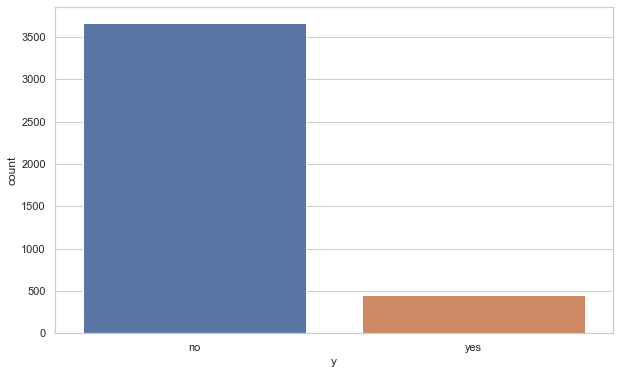

In [8]:
### Q. Find out in the target column what is the respective count of values
data.y.value_counts()
### Q. Also plot the values of y in form of a bar graph
plt.figure(figsize=(10,6))
sns.countplot(x='y',data=data)

In [9]:
data.y.value_counts()

no     3668
yes     451
Name: y, dtype: int64

There are 3668 no's and 451 yes's in the outcome variables.

Let's get a sense of the numbers across the two classes

In [10]:
## Create a visualization as shown below for variable 'job' and frequency of purchase

Text(0.5, 1.0, 'Purchase Frequency for Job Title')

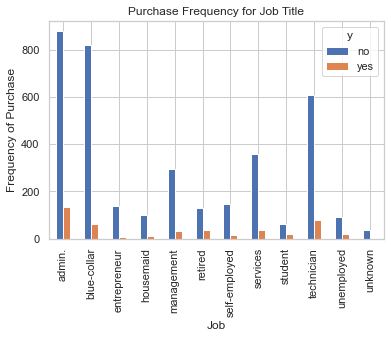

In [11]:
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.ylabel('Frequency of Purchase')
plt.xlabel('Job')
plt.title('Purchase Frequency for Job Title')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

In [12]:
### Create a stacked bar chart between variables 'Education','Purchase' and Proportion of Customers

In [13]:
# For this chart we need prepare a column for percentage of count for yes or no for education categories
# we need to remove data with having count in only yes or in only no, so we found illiterate so droping that row
drrop = data[data['education'] == 'illiterate']
drrop

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
3926,42,retired,divorced,illiterate,no,no,no,cellular,aug,wed,...,4,999,0,nonexistent,-2.9,92.201,-31.4,0.834,5076.2,no


In [14]:
data = data.drop([3926],axis=0)

In [15]:
# Creating a table for preparing bar chart as per requirement
data2 = data[['education','y']].groupby('y').value_counts().reset_index(name='Counts').sort_values('education')
data2['proportion'] = data2['Counts']/data2.groupby('education')['Counts'].transform('sum')
data2

,y,education,Counts,proportion
0,no,Basic,1133,0.920390
6,yes,Basic,98,0.079610
2,no,high.school,824,0.894680
7,yes,high.school,97,0.105320
3,no,professional.course,470,0.878505
8,yes,professional.course,65,0.121495
1,no,university.degree,1099,0.869462
5,yes,university.degree,165,0.130538
4,no,unknown,141,0.844311
9,yes,unknown,26,0.155689


In [16]:
# creating the list count of yes and no as per proprtion column
c_y=list(data2.loc[data2['y']=='yes']['proportion'])
c_n=list(data2.loc[data2['y']=='no']['proportion'])

In [17]:
# creating the list count of yes and no as per education column
edu_y=list(data2.loc[data2['y']=='yes']['education'])
edu_n=list(data2.loc[data2['y']=='no']['education'])

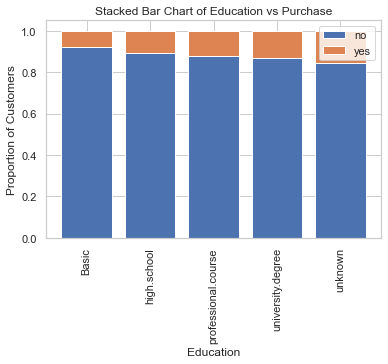

In [18]:
#stacked bar chart between variables 'Education','Purchase' and Proportion of Customers
plt.bar(edu_n,c_n)
plt.bar(edu_y,c_y,bottom =c_n)

plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.title('Stacked Bar Chart of Education vs Purchase')

plt.legend(data2['y'])

plt.xticks(rotation = 90)

plt.show()

Education seems a good predictor of the outcome variable.

In [19]:
## Q. Write code for the visualization as shown below

Text(0.5, 1.0, 'Purchase Frequency for Month')

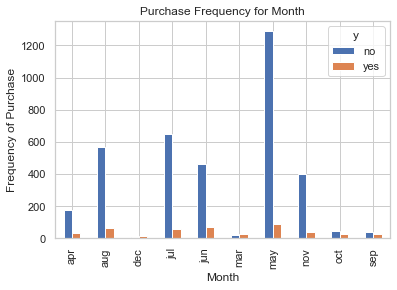

In [20]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.ylabel('Frequency of Purchase')
plt.xlabel('Month')
plt.title('Purchase Frequency for Month')

Month might be a good predictor of the outcome variable

In [21]:
## Q. Write code for the visualization as shown below

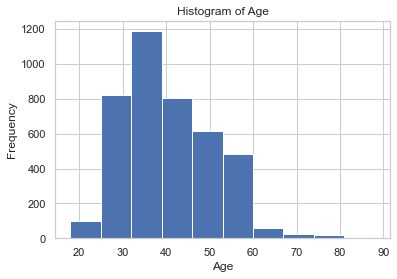

In [22]:
plt.hist(data['age'])
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Histogram of Age');

The most of the customers of the bank in this dataset are in the age range of 30-40.

In [23]:
## Write code to convert following columns to equivalent dummy variables

cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data1 = pd.concat([data,pd.get_dummies(data,columns=cat_vars,drop_first=True)], axis =1)
data1 = data1.drop(columns=cat_vars)

In [24]:
data3 = data1.loc[:,~data1.T.duplicated(keep='first')]

In [25]:
data3

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,1,0,0,0,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,...,1,0,0,0,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0,0,0,0,0,0,0,1,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,0,0,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,53,1,999,0,1.4,93.918,-42.7,4.958,5228.1,...,0,0,0,0,0,1,0,0,1,0
4115,39,219,1,999,0,1.4,93.918,-42.7,4.959,5228.1,...,0,0,0,0,0,0,0,0,1,0
4116,27,64,2,999,1,-1.8,92.893,-46.2,1.354,5099.1,...,1,0,0,0,1,0,0,0,0,0
4117,58,528,1,999,0,1.4,93.444,-36.1,4.966,5228.1,...,0,0,0,0,0,0,0,0,1,0


### Feature Selection

In [26]:
data3['y']

0       no
1       no
2       no
3       no
4       no
        ..
4114    no
4115    no
4116    no
4117    no
4118    no
Name: y, Length: 4118, dtype: object

In [27]:
# for RFE we need to convert yes and no to 0 and 1
data3['y'] = data3['y'].replace('no',0)
data3['y'] = data3['y'].replace('yes',1)

C:\Users\Viren\AppData\Local\Temp\ipykernel_7124\885217405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['y'] = data3['y'].replace('no',0)
C:\Users\Viren\AppData\Local\Temp\ipykernel_7124\885217405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['y'] = data3['y'].replace('yes',1)


In [28]:
## Find the best posible features using feature engineering techniques. 

from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier()
lr = LogisticRegressionCV(max_iter=500)
rfe = RFE(estimator=LogisticRegressionCV(),n_features_to_select=18)
X=data3.drop(columns='y',axis=1)
y=data3['y']

In [29]:
fit=rfe.fit(X,y)

C:\Users\Viren\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Viren\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [30]:
fit.support_

array([False, False, False, False,  True, False, False, False,  True,
       False,  True,  True, False,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True, False, False,
       False, False,  True,  True])

For example --

The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", "poutcome_failure", "poutcome_nonexistent", "poutcome_success".

In [31]:
cols=X.columns[rfe.support_]

In [32]:
cols

Index(['previous', 'euribor3m', 'job_blue-collar', 'job_entrepreneur',
       'job_management', 'job_self-employed', 'job_services',
       'education_unknown', 'housing_unknown', 'contact_telephone',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_sep', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [33]:
X=data3[cols]
y=data3['y']

### Implementing the model

### Logistic Regression Model Fitting

In [34]:
## Write code to implement Logistic Regression module by training the X,Y variables and perform prediction on the Test dataset.

In [35]:
# Splitting the dataset using train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.30)

In [36]:
model = LogisticRegressionCV(
           penalty='l2'
          ,scoring='roc_auc'
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
          ,cv=10)

In [37]:
model.fit(X_train,y_train)

LogisticRegressionCV(cv=10, max_iter=10000, random_state=42, scoring='roc_auc',
                     solver='newton-cg', tol=10)

In [38]:
y_pred = model.predict(X_test)

In [39]:
x_train_pred = model.predict(X_train)

### Confusion Matrix

In [40]:
## Create and Analyze the confusion matrix

[[1093   13]
 [ 108   22]]


C:\Users\Viren\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


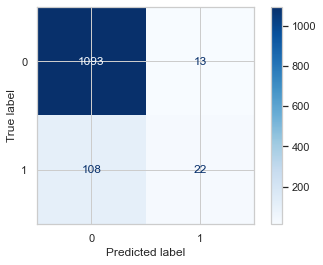

In [41]:
cf_matrix=confusion_matrix(y_test,y_pred)
print(cf_matrix)
plot_confusion_matrix(model,X_test,y_test,cmap=plt.cm.Blues)

In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1106
           1       0.63      0.17      0.27       130

    accuracy                           0.90      1236
   macro avg       0.77      0.58      0.61      1236
weighted avg       0.88      0.90      0.88      1236



### ROC/AUC

In [43]:
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve

In [44]:
## Check for ROC and Area under the curve.

C:\Users\Viren\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


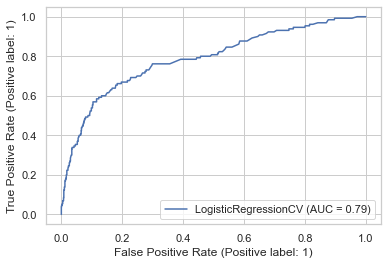

In [45]:
plot_roc_curve(model,X_test,y_test);

In [46]:
## Calculate and analyze the Recall and precision

C:\Users\Viren\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


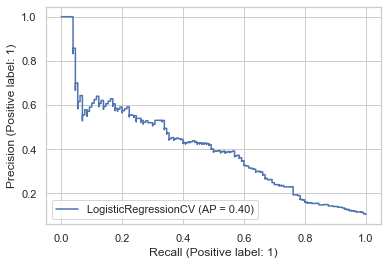

In [47]:
plot_precision_recall_curve(model,X_test,y_test)

### Accuracy

In [48]:
## Find the accuracy of your model

In [49]:
Accuracy_train = accuracy_score(x_train_pred,y_train)
Accuracy_train

0.9028452463566967

In [50]:
Accuracy_test = accuracy_score(y_pred,y_test)
Accuracy_test

0.9021035598705501

### Cross-validation

In [51]:
## Allow 10-fold cross validation to run on all cores.

# Already considered this in Logistic Regression Model

### Model Tuning

In [52]:
## Tune in different attributes of the model and get better accuracy

In [53]:
# From the Classification report it is definitely understood that data is highly imbalanced 
# as recall and f1 score for yes is very low it is definitely not acceptable
# So, we need to perform Scaling and there perform sampling method to balance the Data

In [54]:
# Scaling of Data using Standard Scaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [55]:
# using SMOTE for oversampling
smt = SMOTE(k_neighbors=5, random_state=2)
X_train_smt, y_train_smt = smt.fit_resample(scaled_X_train, y_train)

In [56]:
model_1 = LogisticRegressionCV(
           penalty='l2'
          ,scoring='roc_auc'
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
          ,cv=10)

In [57]:
model_1.fit(X_train_smt,
           y_train_smt)

LogisticRegressionCV(cv=10, max_iter=10000, random_state=42, scoring='roc_auc',
                     solver='newton-cg', tol=10)

Accuracy of Training Data is: 0.7730742539902845
Accuracy of Test Data is: 0.7588996763754046
----------------------------------------
----------------------------------------
classification_report:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1106
           1       0.23      0.54      0.32       130

    accuracy                           0.76      1236
   macro avg       0.58      0.66      0.59      1236
weighted avg       0.86      0.76      0.80      1236

----------------------------------------
----------------------------------------
Confusion Matrix:


C:\Users\Viren\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(
C:\Users\Viren\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(
C:\Users\Viren\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Viren\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


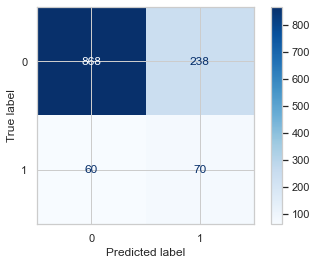

In [58]:
# Evaluting model using different metrics 
y_pred_1 = model.predict(scaled_X_test)
x_train_pred1 = model.predict(scaled_X_train)


Accuracy_train = accuracy_score(x_train_pred1,y_train)
print('Accuracy of Training Data is:',Accuracy_train)

Accuracy_test = accuracy_score(y_pred_1,y_test)
print('Accuracy of Test Data is:',Accuracy_test)

print('----------------------------------------')
print('----------------------------------------')
print('classification_report:')

print(classification_report(y_test,y_pred_1))

print('----------------------------------------')
print('----------------------------------------')
print('Confusion Matrix:')
plot_confusion_matrix(model,scaled_X_test,y_test,cmap=plt.cm.Blues);



C:\Users\Viren\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


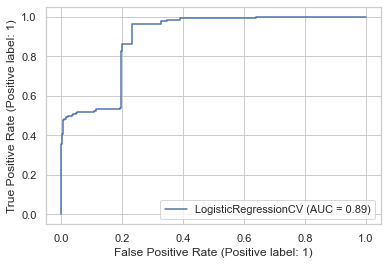

In [59]:
plot_roc_curve(model_1,scaled_X_test,y_pred_1)

C:\Users\Viren\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


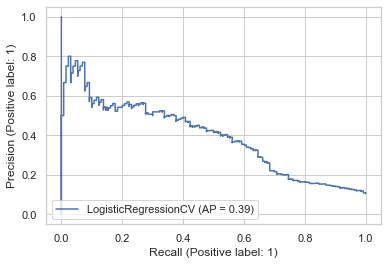

In [60]:
plot_precision_recall_curve(model_1,scaled_X_test,y_test)

# Conclusion

- After performing the above test we can surely say that model with **SMOTE** sampling has performed much better this is because recall for target 1 has increased alot and F1 score too has increased.


- as infered from the different plots we can implement actions to work on it, and can try to improve those things for better outcome. 